In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset,DataLoader,random_split
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Subset
from collections import defaultdict
import os
import random
from torchmetrics import Accuracy, F1Score, Precision, Recall

c:\Users\bhatu\OneDrive\Desktop\NN\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random.seed(42)  # For reproducibility
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),#Augmenting data by adding random horizontal flips, Simulate different view points of weather
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(), #Randomly changing the brightness of the image
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the full dataset
dataset = ImageFolder("dataset", transform=train_transforms)

# Create a mapping from class index to list of indices
class_to_indices = defaultdict(list)
for idx, (_, class_idx) in enumerate(dataset.samples):
    class_to_indices[class_idx].append(idx)

# Take 70% of each class
train_indices = []
for class_idx, indices in class_to_indices.items():
    num_samples = int(0.7 * len(indices))
    selected = random.sample(indices, num_samples)
    train_indices.extend(selected)

# Create the subset
dataset_train = Subset(dataset, train_indices)
dataset_train

print(dataset.class_to_idx)

{'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}


In [6]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

image, label = next(iter(dataloader_train))
print(image.shape, label.shape) # 1 --  batch size, 3 -- color channels, 128 -- height, 128 -- width

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [7]:
image = image[0]
image = image.squeeze().permute(1,2,0) # remove the batch dimension and permute to (height, width, channels)
image.shape


torch.Size([128, 128, 3])

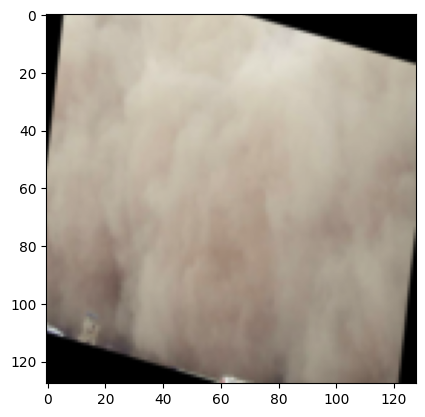

In [8]:
plt.imshow(image)
plt.show()

In [9]:
class Net(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential( # Feature extractor that consists of convolutional layers and pooling layers.
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # First convolutional layer that has 32 filters with 3x3 patch size and a window size of 1. Channels = 3 for (R,G,B)
            nn.ReLU(), # Activation function to introduce non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2), # Pooling layer to reduce the spatial dimensions of the feature maps/conv layers while maintaining the most important information.
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(), # Flatten the output from the convolutional layers to feed into the fully connected layers.
        )

        self.classifer = nn.Sequential(
            nn.Linear(64*32*32, num_classes), # Fully connected layer that takes the flattened output from the feature extractor and finds probability distribution of the classes.
        )# Classifier that consists of fully connected layers.
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifer(x)
        return x

In [102]:
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA available? {torch.cuda.is_available()}")
print(f"Device being used: {device}")
net = Net(num_classes=11).to(device=device) # Create an instance of the Net class and move it to the device (GPU or CPU).
loss_func  = CrossEntropyLoss() # Loss function to measure the difference between the predicted and true labels.
optimizer = optim.Adam(net.parameters(), lr=0.001) # Optimizer to update the weights of the model during training.

epochs = 35 # Number of epochs to train the model.
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # Zero the gradients before the backward pass.
        outputs = net(images) # Forward pass through the network.
        loss = loss_func(outputs, labels) # Calculate the loss.
        loss.backward() # Backward pass to calculate gradients.
        optimizer.step() # Update the weights using the optimizer.

        running_loss += loss.item() # Accumulate the loss.

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader_train):.4f}") # Print the average loss for each epoch.

torch.save(net.state_dict(), "weather_model.pth")
print("Model saved to weather_model.pth")


NVIDIA GeForce RTX 3050 Ti Laptop GPU
CUDA available? True
Device being used: cuda
Epoch [1/35], Loss: 1.5612
Epoch [2/35], Loss: 1.1409
Epoch [3/35], Loss: 1.0638
Epoch [4/35], Loss: 0.9980
Epoch [5/35], Loss: 0.9653
Epoch [6/35], Loss: 0.9468
Epoch [7/35], Loss: 0.9186
Epoch [8/35], Loss: 0.8958
Epoch [9/35], Loss: 0.8791
Epoch [10/35], Loss: 0.8506
Epoch [11/35], Loss: 0.8653
Epoch [12/35], Loss: 0.8337
Epoch [13/35], Loss: 0.8342
Epoch [14/35], Loss: 0.7985
Epoch [15/35], Loss: 0.7822
Epoch [16/35], Loss: 0.7884
Epoch [17/35], Loss: 0.7873
Epoch [18/35], Loss: 0.7566
Epoch [19/35], Loss: 0.7484
Epoch [20/35], Loss: 0.7198
Epoch [21/35], Loss: 0.7319
Epoch [22/35], Loss: 0.7126
Epoch [23/35], Loss: 0.7075
Epoch [24/35], Loss: 0.6805
Epoch [25/35], Loss: 0.6777
Epoch [26/35], Loss: 0.6760
Epoch [27/35], Loss: 0.6893
Epoch [28/35], Loss: 0.6697
Epoch [29/35], Loss: 0.6550
Epoch [30/35], Loss: 0.6447
Epoch [31/35], Loss: 0.6430
Epoch [32/35], Loss: 0.6193
Epoch [33/35], Loss: 0.6243
Ep

In [103]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Create a mapping from class index to list of indices
class_to_indices = defaultdict(list)
for idx, (_, class_idx) in enumerate(dataset.samples):
    class_to_indices[class_idx].append(idx)

# Take 30% of each class
test_indices = []
for class_idx, indices in class_to_indices.items():
    num_samples = int(0.3 * len(indices))
    selected = random.sample(indices, num_samples)
    test_indices.extend(selected)

# Create the subset
dataset_test = Subset(dataset, test_indices)
dataset_test

In [104]:
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)

image_test, label_test = next(iter(dataloader_test))
print(image_test.shape, label_test.shape) # 1 --  batch size, 3 -- color channels, 128 -- height, 128 -- width

torch.Size([1, 3, 128, 128]) torch.Size([1])


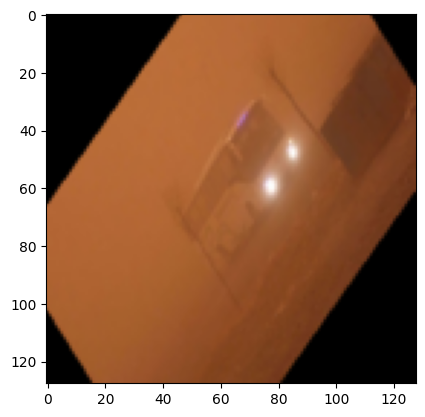

In [82]:
image_test = image_test.squeeze().permute(1,2,0) # remove the batch dimension and permute to (height, width, channels)
plt.imshow(image_test)
plt.show()

In [105]:
recall_macro = Recall(task="multiclass",num_classes=11, average='macro').to(device) # Recall score across multiple classes, takes average of recall scores for each class.
accuracy_macro = Accuracy(task="multiclass",num_classes=11, average='macro').to(device) # Accuracy score across multiple classes, takes average of accuracy scores for each class.
recall_per_class = Recall(task="multiclass",num_classes=11, average=None).to(device) # Recall score for each class.
accuracy_per_class = Accuracy(task="multiclass",num_classes=11, average=None).to(device) # Accuracy score for each class.

In [106]:
net.eval()

with torch.no_grad():
    for images,labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        recall_macro.update(predicted, labels) # Update the recall score with the predicted and true labels.
        recall_per_class.update(predicted, labels)
        accuracy_per_class.update(predicted, labels)
        accuracy_macro.update(predicted, labels)
recall = recall_macro.compute() # Compute the recall score.
accuracy = accuracy_macro.compute() # Compute the accuracy score.
print(f"Recall: {recall:.4f}") # Print the recall score.
print(f"Accuracy: {accuracy:.4f}") # Print the accuracy score.
print(f"Recall per class: {recall_per_class.compute()}") # Print the recall score for each class.
print(f"Accuracy per class: {accuracy_per_class.compute()}") # Print the accuracy score for each class.


Recall: 0.7555
Accuracy: 0.7555
Recall per class: tensor([0.8421, 0.8314, 0.5915, 0.6387, 0.7119, 0.8850, 0.8662, 0.8116, 0.8764,
        0.8792, 0.3763], device='cuda:0')
Accuracy per class: tensor([0.8421, 0.8314, 0.5915, 0.6387, 0.7119, 0.8850, 0.8662, 0.8116, 0.8764,
        0.8792, 0.3763], device='cuda:0')
